In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
import time
import itertools
import h2o
import os
import pickle

### Data Cleaning

In [5]:
train = pd.read_csv('Training_Dataset_v2.csv')
test = pd.read_csv('Test_Dataset_v2.csv')

In [6]:
#Preview Data
print("Train Data :",train.shape)
print("Test Data :",test.shape)

Train Data : (1687861, 23)
Test Data : (242076, 23)


In [7]:
print('-'*50,'\n','Train columns with null values:\n','-'*50, '\n',train.isnull().sum().sort_values(),'\n','-'*50,'\n')

print('Test/Validation columns with null values:\n','-'*50,'\n', test.isnull().sum().sort_values(),'\n','-'*50,'\n')

-------------------------------------------------- 
 Train columns with null values:
 -------------------------------------------------- 
 sku                       0
stop_auto_buy             1
ppap_risk                 1
oe_constraint             1
deck_risk                 1
local_bo_qty              1
perf_12_month_avg         1
perf_6_month_avg          1
pieces_past_due           1
potential_issue           1
rev_stop                  1
min_bank                  1
sales_6_month             1
sales_3_month             1
sales_1_month             1
forecast_9_month          1
forecast_6_month          1
forecast_3_month          1
in_transit_qty            1
national_inv              1
sales_9_month             1
went_on_backorder         1
lead_time            100894
dtype: int64 
 -------------------------------------------------- 

Test/Validation columns with null values:
 -------------------------------------------------- 
 sku                      0
stop_auto_buy            1

In [9]:
dataset = pd.concat([train,test],axis=0)

In [10]:
dataset.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.85,0.83,0.0,0,0,0,0,0,0
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.99,0.99,0.0,0,0,0,0,0,0
2,1043696,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.85,0.83,0.0,1,0,0,0,0,0
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.10,0.13,0.0,0,0,0,0,0,0
4,1044048,8.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.85,0.83,0.0,1,0,0,0,0,0


In [12]:
continuous_var = ['national_inv','lead_time','in_transit_qty','forecast_3_month','forecast_6_month',
           'forecast_9_month','sales_1_month','sales_3_month','sales_6_month','sales_9_month',
           'min_bank','pieces_past_due','perf_6_month_avg','perf_12_month_avg','local_bo_qty']

categorical_var = ['potential_issue','deck_risk','oe_constraint','ppap_risk','stop_auto_buy',
            'rev_stop','went_on_backorder']
categorical_pred = ['potential_issue','deck_risk','oe_constraint','ppap_risk','stop_auto_buy',
            'rev_stop']

##### Descriptive Statistical Analysis

In [13]:
#------Continuous Var------------
dataset[continuous_var].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
national_inv,1929935.0,496.568259,29573.434344,-27256.0,4.00,15.00,80.00,12334404.0
lead_time,1929935.0,7.885898,6.839711,0.0,4.00,8.00,8.00,52.0
in_transit_qty,1929935.0,43.064397,1295.420493,0.0,0.00,0.00,0.00,489408.0
forecast_3_month,1929935.0,178.539864,5108.770174,0.0,0.00,0.00,4.00,1510592.0
forecast_6_month,1929935.0,345.465893,9831.562085,0.0,0.00,0.00,12.00,2461360.0
forecast_9_month,1929935.0,506.606748,14345.430866,0.0,0.00,0.00,20.00,3777304.0
sales_1_month,1929935.0,55.368164,1884.377009,0.0,0.00,0.00,4.00,741774.0
sales_3_month,1929935.0,174.663858,5188.855852,0.0,0.00,1.00,15.00,1105478.0
sales_6_month,1929935.0,341.565349,9585.030376,0.0,0.00,2.00,31.00,2146625.0
sales_9_month,1929935.0,523.577094,14733.265629,0.0,0.00,4.00,47.00,3205172.0


In [13]:
#means of OOS
print('Mean Pivot Table')
dataset.pivot_table(values=continuous_var,index=['went_on_backorder'],aggfunc=['mean'])

Mean Pivot Table


mean                                    \
                  forecast_3_month forecast_6_month forecast_9_month   
went_on_backorder                                                      
0                       178.566740       345.974100       507.636728   
1                       174.856734       275.821257       365.458479   

                                                                    \
                  in_transit_qty lead_time local_bo_qty   min_bank   
went_on_backorder                                                    
0                      43.344159  7.890117     0.626744  52.962026   
1                       4.725842  6.354233     4.348258  27.333524   

                                                                   \
                  national_inv perf_12_month_avg perf_6_month_avg   
went_on_backorder                                                   
0                   500.036607          0.777450         0.782579   
1                    21.266361          0.703794         0.705853   

                                                                             \
                  pieces_past_due sales_1_month sales_3_month sales_6_month   
went_on_backorder                                                             
0                        2.003972     55.556432    175.322597    342.979619   
1                        3.691009     29.567914     84.390315    147.753952   

                                 
                  sales_9_month  
went_on_backorder                
0                    525.812742  
1                    217.204134

In [14]:
#---Categorical variables-----#

#Percentage of each categorical variable
for col in categorical_var:
    print(col,": ",round(dataset[col].mean()*100,2),"%" )

potential_issue :  0.05 %
deck_risk :  22.56 %
oe_constraint :  0.02 %
ppap_risk :  12.05 %
stop_auto_buy :  3.66 %
rev_stop :  0.04 %
went_on_backorder :  0.72 %


In [15]:
#Proportions of categorical predictors stratified by went_on_backorder
dataset.pivot_table(values=(categorical_pred),index=["went_on_backorder"])

,deck_risk,oe_constraint,potential_issue,ppap_risk,rev_stop,stop_auto_buy
went_on_backorder,,,,,,
0,0.226089,0.000148,0.000488,0.120264,0.000436,0.036518
1,0.162864,0.000644,0.003862,0.152421,0.000286,0.041342


##### missing value treatment

In [16]:
#View count/percentage of missing cells
tot=dataset.isnull().sum().sort_values(ascending=False)
perc=(round(100*dataset.isnull().sum()/dataset.isnull().count(),1)).sort_values(ascending=False)
missing_data = pd.concat([tot, perc], axis=1, keys=['Missing', 'Percent'])

In [17]:
missing_data.head(3)

,Missing,Percent
perf_6_month_avg,148579,7.7
perf_12_month_avg,140025,7.3
lead_time,115617,6.0


In [18]:
#create a variable for any missing data
dataset['anymissing']=(  pd.isnull(dataset['perf_6_month_avg'] ) | 
                        pd.isnull(dataset['perf_12_month_avg'] ) | 
                        pd.isnull(dataset['lead_time'] ) ).astype(int)

In [19]:
##Compare complete data to data with any missing variables
##By continuous_var
##By categorical_var

dataset.pivot_table(values=(continuous_var),index=['anymissing'])

,forecast_3_month,forecast_6_month,forecast_9_month,in_transit_qty,lead_time,local_bo_qty,min_bank,national_inv,perf_12_month_avg,perf_6_month_avg,pieces_past_due,sales_1_month,sales_3_month,sales_6_month,sales_9_month
anymissing,,,,,,,,,,,,,,,
0,190.816173,368.979564,540.913775,44.235561,7.783747,0.665692,51.809120,378.984118,0.778599,0.782,2.134941,55.902779,176.628317,349.037103,537.452417
1,31.355690,63.553786,95.290021,29.022978,13.006159,0.509971,64.372953,1906.318053,0.422221,NaN,0.592493,48.958514,151.111389,251.984358,357.221882


In [20]:
dataset.pivot_table(values=(categorical_var),index=['anymissing'])

,deck_risk,oe_constraint,potential_issue,ppap_risk,rev_stop,stop_auto_buy,went_on_backorder
anymissing,,,,,,,
0,0.197284,0.000164,0.000539,0.116859,0.000237,0.023113,0.007538
1,0.565490,0.000000,0.000188,0.164115,0.002807,0.197679,0.003729


By comparing descriptive statistics of the data, we find that any missing values doesnot occur at random. Hence we are choosing median to fill the nan values

In [15]:
#recode binary variables as 0 / 1 from than No / Yes
for col in ['potential_issue',
            'deck_risk',
            'oe_constraint',
            'ppap_risk',
            'stop_auto_buy',
            'rev_stop',
            'went_on_backorder']:    
    dataset[col]=pd.factorize(dataset[col])[0]

dataset = dataset[pd.notnull(dataset['national_inv'])]

dataset['perf_6_month_avg']=dataset['perf_6_month_avg'].replace(-99, np.NaN)
dataset['perf_12_month_avg']=dataset['perf_12_month_avg'].replace(-99, np.NaN)

dataset = dataset.fillna(dataset.median())


In [17]:
dataset.reset_index().drop('index',axis=1,inplace=True)

### Quick Data Exploration

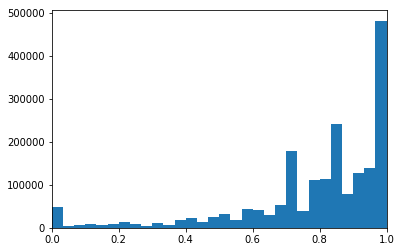

In [18]:
x = dataset.perf_6_month_avg
plt.hist(x, bins = 30)
plt.xlim(0,1)
plt.show()

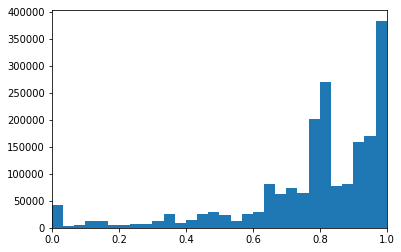

In [19]:
x = dataset.perf_12_month_avg
plt.hist(x, bins = 30)
plt.xlim(0,1)
plt.show()

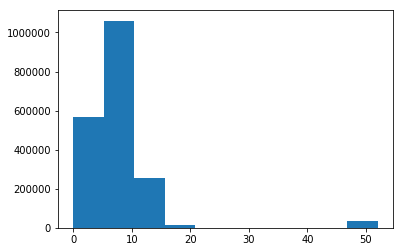

In [20]:
x = dataset.lead_time
plt.hist(x)
plt.show()

### Replacing with median:
observing the plots, we can see that the distribution is either right or left skewed. Thus, replacing the missing values using the median seems like a better option rather than using the mean.

### Forecasting Insights

C:\Users\Sumit Keshav\Anaconda3\envs\tf-gpu\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


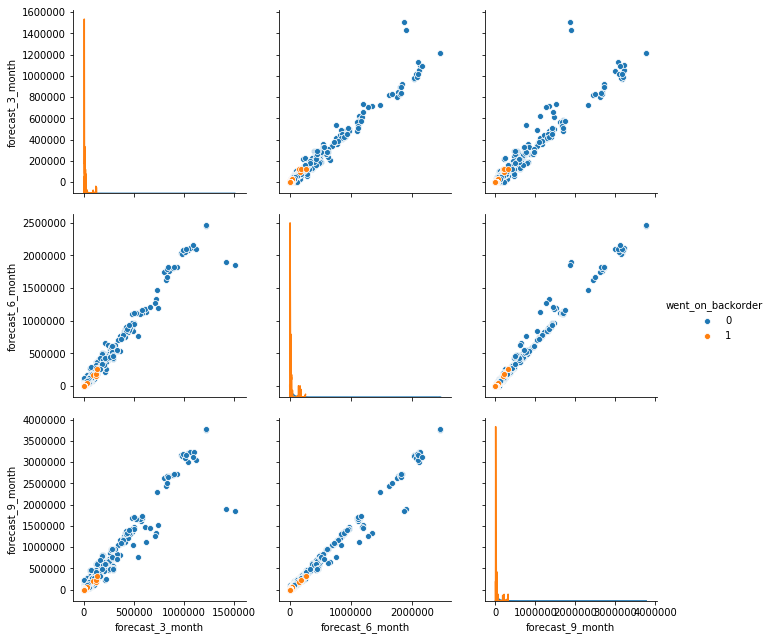

In [21]:
forecasts = ['forecast_3_month','forecast_6_month', 'forecast_9_month']
sns.pairplot(dataset, hue = 'went_on_backorder', vars = forecasts, size = 3 )

C:\Users\Sumit Keshav\Anaconda3\envs\tf-gpu\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


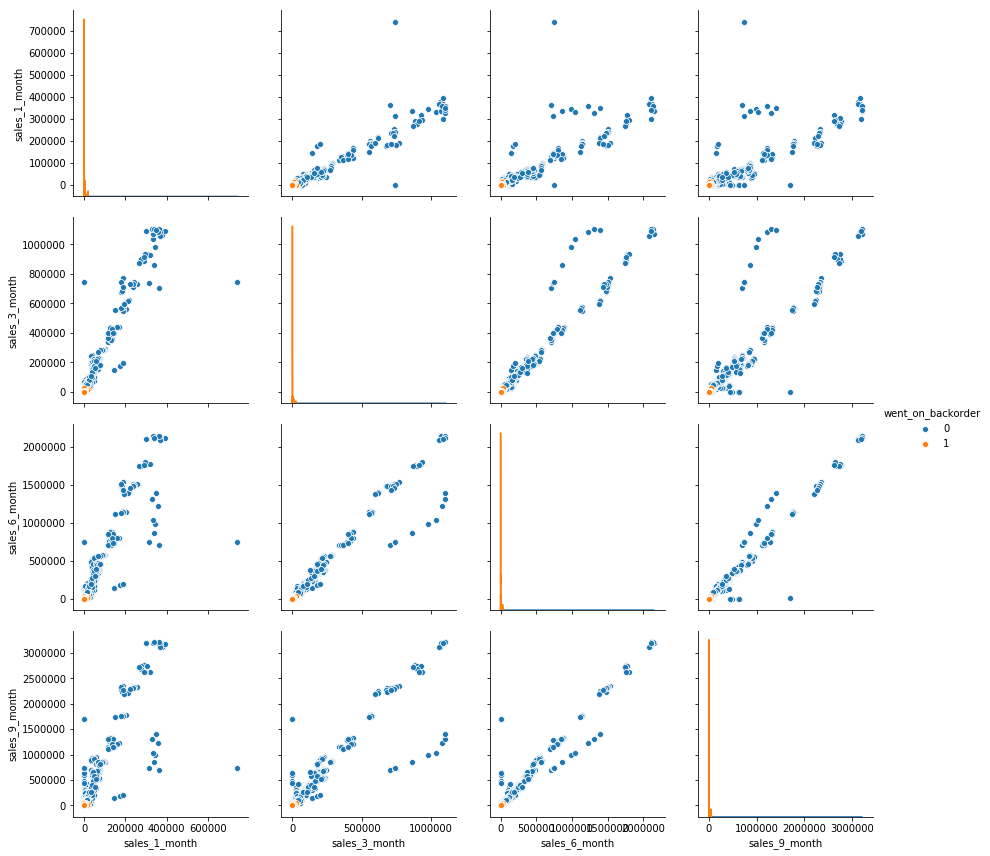

In [22]:
sales = ['sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month']
sns.pairplot(dataset, vars=sales, hue='went_on_backorder', size=3)
plt.show()

### Relation between variables:
We see that the relationship between the variables here is linear and they are highly correlated. Also, we observe that the backorders happen only when the value of sales and forecast is very low.

In [23]:
# Separate data by going on backorder or not
no_bo = dataset.loc[dataset['went_on_backorder'] == 0]       
is_bo = dataset.loc[dataset['went_on_backorder'] == 1]

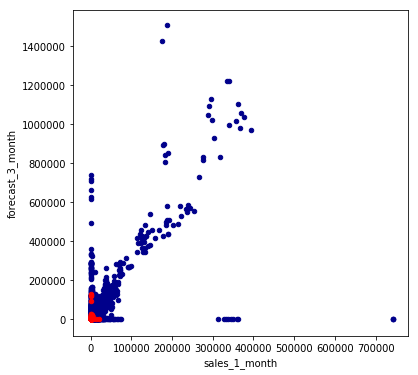

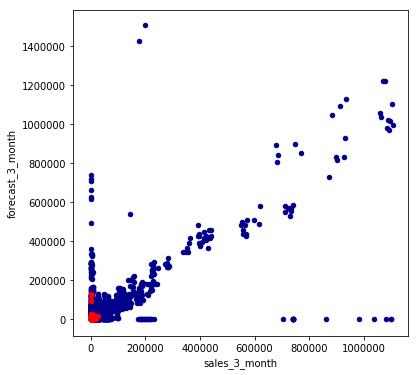

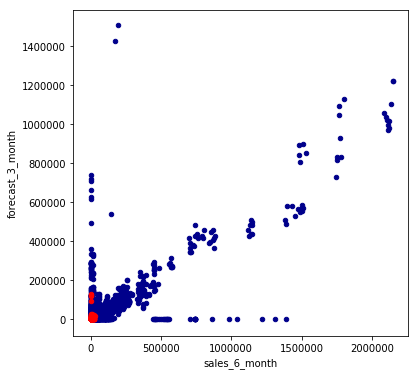

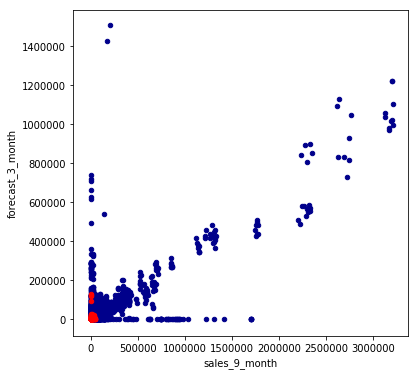

In [24]:
# Make scatter plots of the 3-month forecast against each of the sales
for col in sales:
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()
    no_bo.plot(kind='scatter', x=col, y='forecast_3_month', ax=ax, color='DarkBlue', legend=True)
    is_bo.plot(kind='scatter', x=col, y='forecast_3_month', ax=ax, color='Red')
    plt.show()

Here we can see that the relation between the forecast and the sales follow a linear pattern and have a relatively high correlation between them

#### Look at forecast, sales, in transit and recommended stock level in a pair-wise scatter plot

C:\Users\Sumit Keshav\Anaconda3\envs\tf-gpu\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


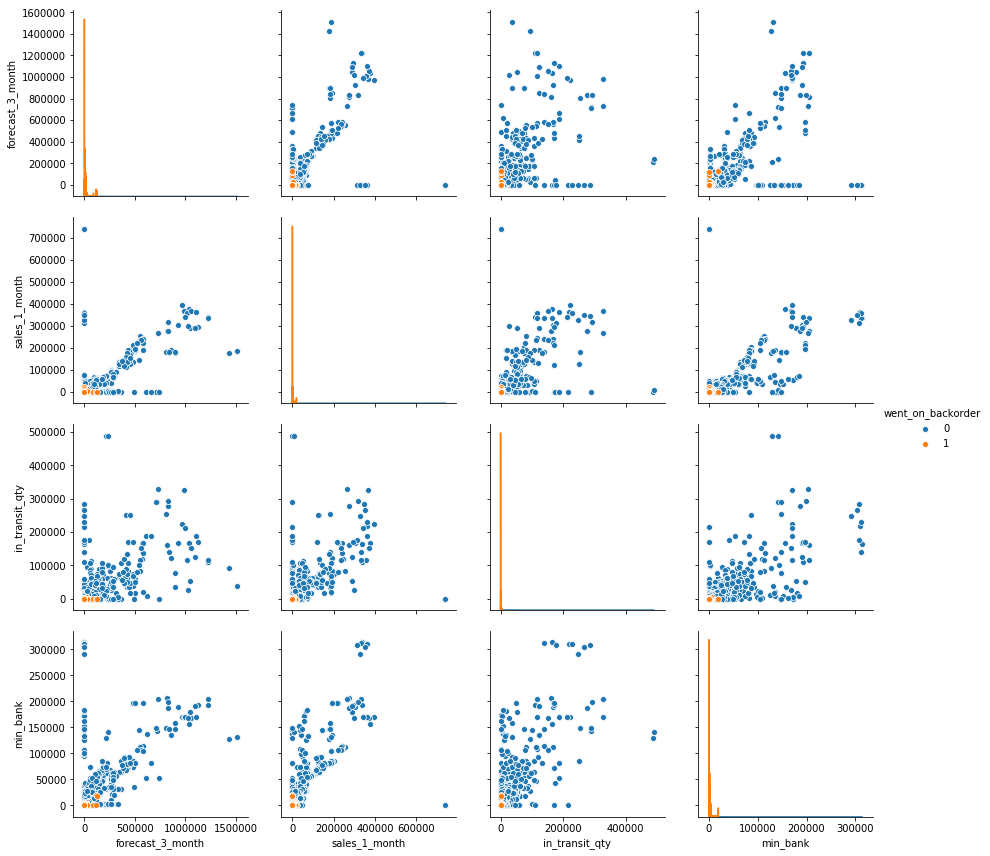

In [25]:
feature_set_1 = ['forecast_3_month', 'sales_1_month', 'in_transit_qty', 'min_bank']
sns.pairplot(dataset, vars=feature_set_1, hue='went_on_backorder', size=3)
plt.show()

### Initialize H2O for Data Analysis

In [31]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM 18.3 (build 10.0.1+10, mixed mode)
  Starting server from C:\Users\Sumit Keshav\Anaconda3\envs\tf-gpu\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\SUMITK~1\AppData\Local\Temp\tmpvtb5725v
  JVM stdout: C:\Users\SUMITK~1\AppData\Local\Temp\tmpvtb5725v\h2o_Sumit_Keshav_started_from_python.out
  JVM stderr: C:\Users\SUMITK~1\AppData\Local\Temp\tmpvtb5725v\h2o_Sumit_Keshav_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.3
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_Sumit_Keshav_yro6fx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.967 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"accepting new members, healthy"


In [32]:
train_df = h2o.import_file(path=os.path.realpath("Training_Dataset_v2.csv"))
test_df = h2o.import_file(path=os.path.realpath("Test_Dataset_v2.csv"))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [33]:
train_df.describe()

Rows:1929935
Cols:22




,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
type,real,real,real,real,real,real,real,real,real,real,real,int,real,real,real,real,int,int,int,int,int,int
mins,-0.9384292377419452,-1.152958052534521,-0.03324357487765281,-0.034947727915245454,-0.035138463188360454,-0.035314859790799895,-0.02938275000219753,-0.033661351912768554,-0.03563530042996836,-0.03553707931142841,-0.04195366569702182,0.0,-0.008780902013356654,-3.44257415711228,-3.507487910981539,-0.018449384704528463,0.0,0.0,0.0,0.0,0.0,0.0
mean,2.9674442145597687e-18,1.1074531262277649e-17,-4.2413098451276104e-18,3.4755177897573474e-17,-2.4151903284754447e-18,-3.9467744392159706e-18,2.238469084928461e-17,-1.867354473479795e-17,-6.840584802297829e-18,-4.5358452510392495e-18,6.479778930056071e-19,0.0005124524919233031,4.939358757138196e-17,1.6399731401160091e-16,-3.213970349307811e-16,7.893548878431941e-18,0.2256309150308171,0.00015130043239798232,0.12049732244868351,0.03655252638042214,0.0004347296670613259,0.007244285429302023
maxs,417.0604767721627,6.449704437463159,377.7654168465989,295.6511645492242,250.31781831957943,263.2753527633493,393.6148767267744,213.01490234663953,223.92041616925525,217.51112983660556,249.02560380333503,1.0,638.0089264190616,0.9304171351692616,0.9849805287152444,353.6138250890764,1.0,1.0,1.0,1.0,1.0,1.0
sigma,1.0000002590761845,1.0000002590761847,1.0000002590761796,1.0000002590761832,1.0000002590761852,1.0000002590761834,1.000000259076183,1.0000002590761827,1.0000002590761825,1.000000259076184,1.0000002590761825,0.02263161836368005,1.0000002590761858,1.0000002590761827,1.0000002590761843,1.000000259076184,0.41799724370574304,0.012299496695473536,0.3255422747416899,0.18766048450090492,0.020845644685070604,0.08480453693271656
zeros,0,0,0,0,0,0,0,0,0,0,0,1928946,0,0,0,0,1494482,1929643,1697383,1859391,1929096,1915954
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,-0.016791028779236085,0.016682330542044804,-0.03324357487765281,-0.034947727915245454,-0.035138463188360454,-0.035314859790799895,-0.02938275000219753,-0.033661351912768554,-0.03563530042996836,-0.03553707931142841,-0.04195366569702182,0.0,-0.008780902013356654,0.2744684413270303,0.22126089396679105,-0.018449384704528463,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.0146945520784844,0.016682330542044804,-0.03324357487765281,-0.034947727915245454,-0.035138463188360454,-0.035314859790799895,-0.02938275000219753,-0.033661351912768554,-0.03563530042996836,-0.03553707931142841,-0.04115873287306594,0.0,-0.008780902013356654,0.2744684413270303,0.22126089396679105,-0.018449384704528463,1.0,0.0,0.0,0.0,0.0,0.0
2,-0.016723400498566677,0.16288737842661558,-0.03324357487765281,-0.034947727915245454,-0.035138463188360454,-0.035314859790799895,-0.02938275000219753,-0.033661351912768554,-0.03563530042996836,-0.03553707931142841,-0.04195366569702182,0.0,-0.008780902013356654,0.8866872222464462,0.9400558443182764,-0.018449384704528463,0.0,0.0,0.0,0.0,0.0,0.0


In [165]:
## Add notes for each feature .describe()
#0.72% of sku's will be out of stock

#### Exploring Data

In [34]:
data_group = train_df.group_by("went_on_backorder").count()
data_group.get_frame()

went_on_backorder,nrow
0,1.91595e+06
1,13981


In [35]:
train_df.as_data_frame()['went_on_backorder'].value_counts()

0    1915954
1      13981
Name: went_on_backorder, dtype: int64

##### Density Plot

We group first the data by went_on_backorder. We use kdeplot to visualize the data distribution.

<Figure size 432x288 with 0 Axes>

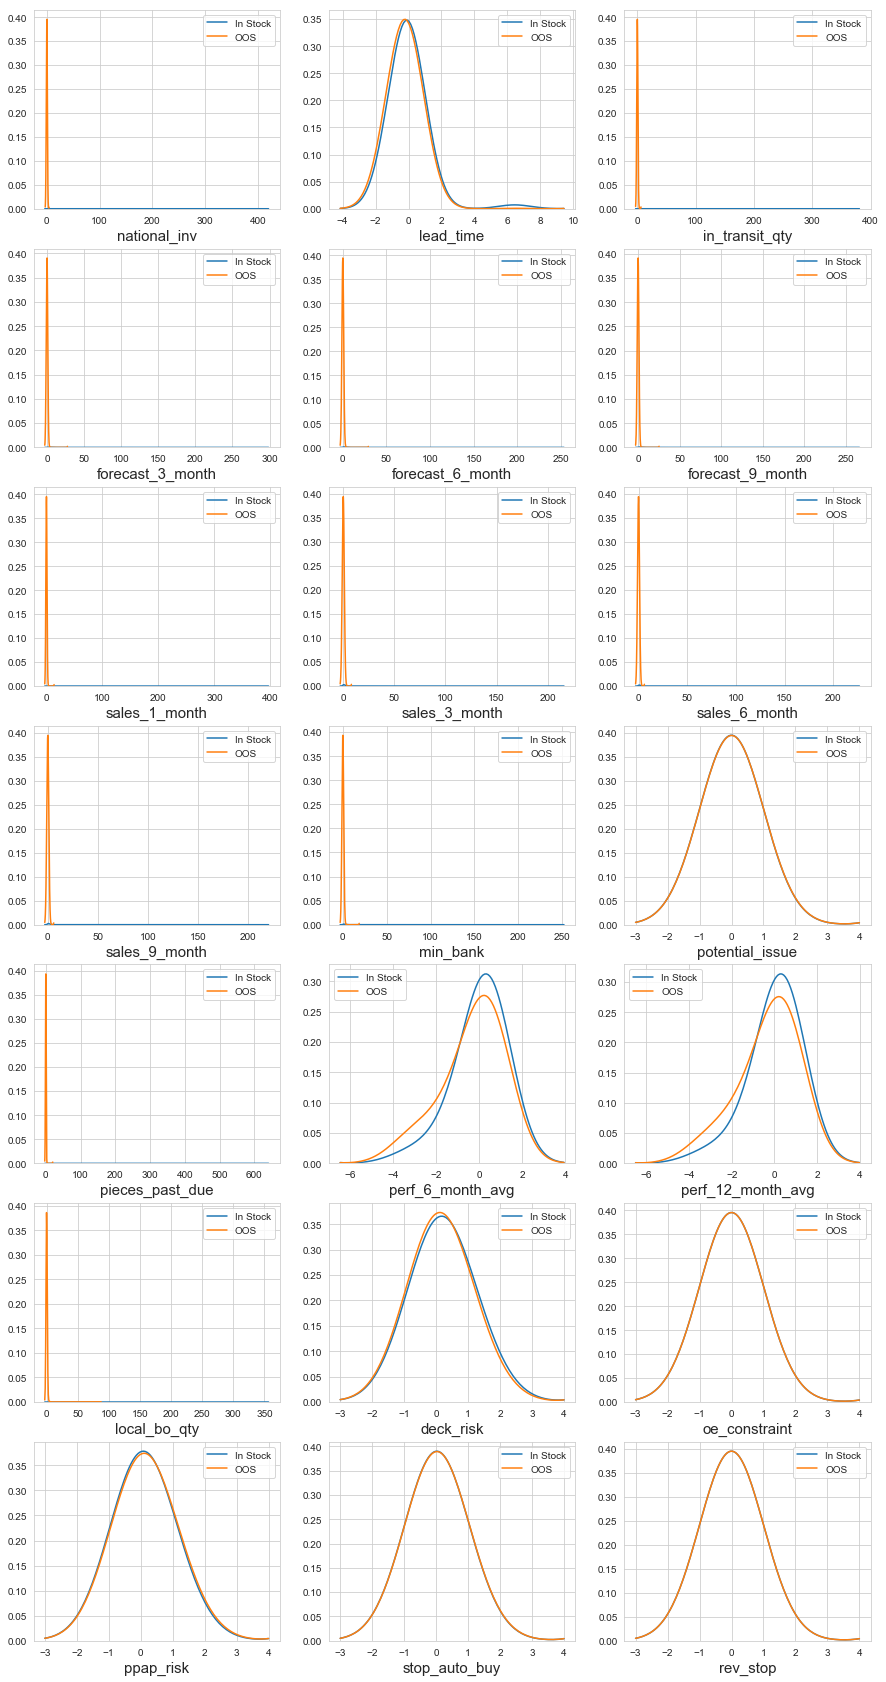

In [36]:
features = [f for f in train_df.columns if f not in ['went_on_backorder']]
i=0
t0 = train_df[train_df['went_on_backorder']==0].as_data_frame()
t1 = train_df[train_df['went_on_backorder']==1].as_data_frame()

sns.set_style('whitegrid')
plt.figure()
fig,ax = plt.subplots(7,3,figsize=(15,30))

for feature in features:
    i+=1
    plt.subplot(7,3,i)
    sns.kdeplot(t0[feature],bw=1,label="In Stock")
    sns.kdeplot(t1[feature],bw=1,label="OOS")
    plt.xlabel(feature,fontsize=15)
    locs,labels = plt.xticks()
    plt.tick_params(axis='both',which = 'major',labelsize=10)
plt.show()

In [37]:
# DownSampling the train data for better visualizations
from fractions import Fraction

In [38]:
ratio = train_df.as_data_frame()['went_on_backorder'].value_counts()[0]/train_df.as_data_frame()['went_on_backorder'].value_counts()[1]

In [39]:
ratio

137.03983978256204

In [40]:
#dividing in 3:1
from sklearn.utils import resample

In [41]:
tr = train_df.as_data_frame()
tr_majority = tr[tr['went_on_backorder']==0]
tr_minority = tr[tr['went_on_backorder']==1]
n_sam = len(tr_minority)
tr_majority_downsample = resample(tr_majority,n_samples=n_sam,replace=False,random_state=123)

In [42]:
tr = pd.concat([tr_majority_downsample,tr_minority])
#tr.drop('sku',axis=1,inplace=True)

<Figure size 432x288 with 0 Axes>

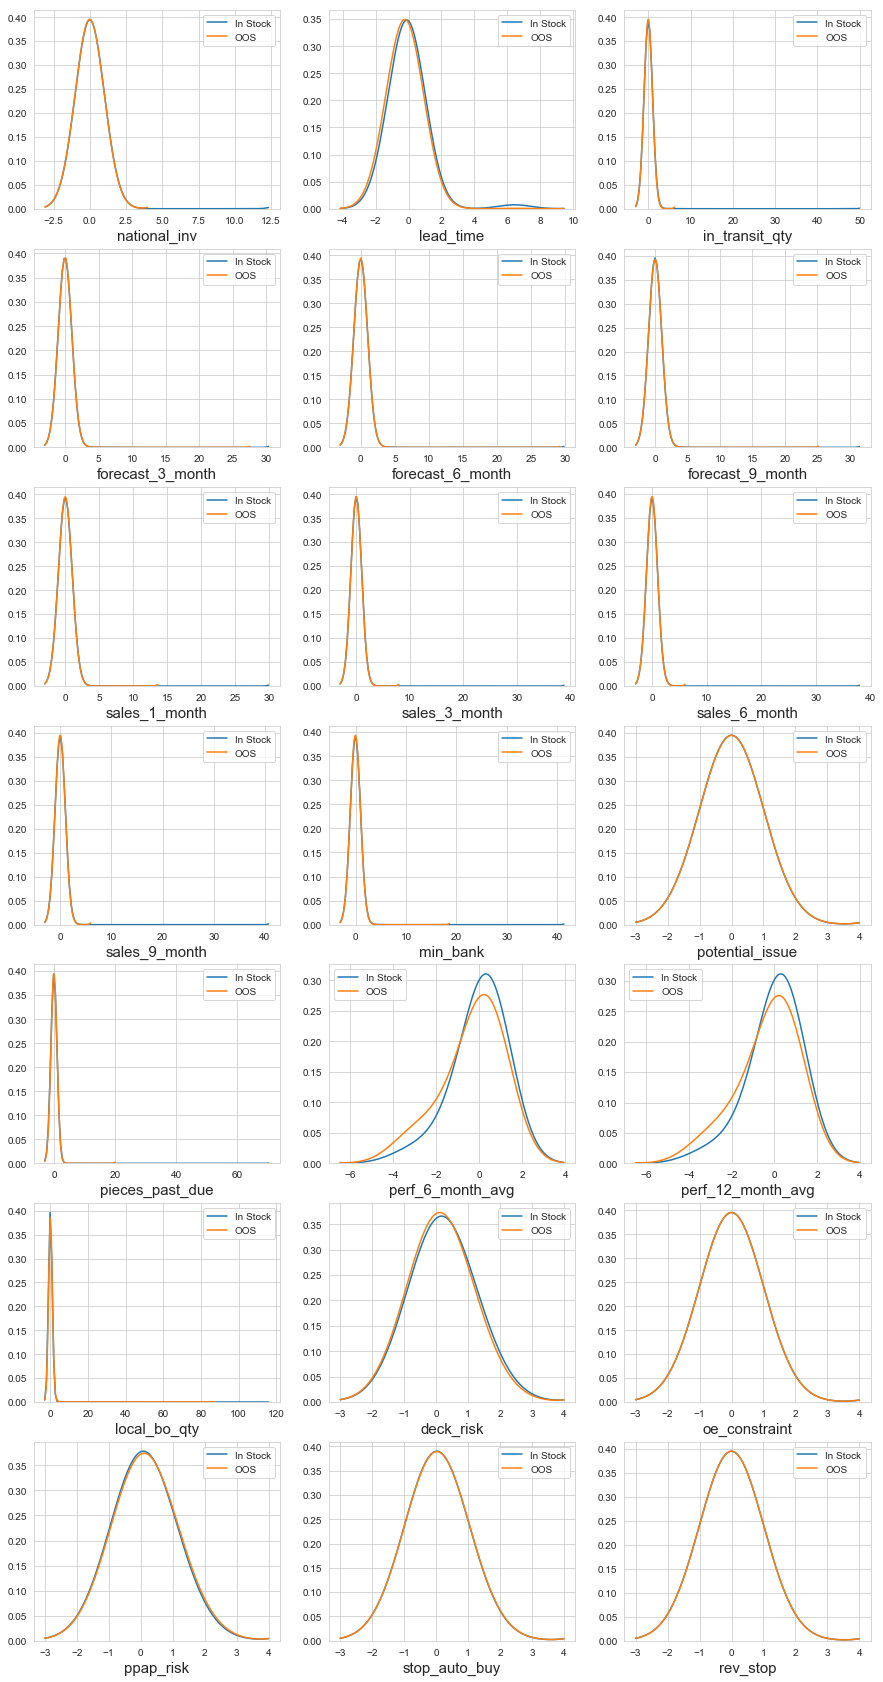

In [43]:
features = [f for f in tr.columns if f not in ['went_on_backorder']]
i=0
t0 = tr[tr['went_on_backorder']==0]
t1 = tr[tr['went_on_backorder']==1]

sns.set_style('whitegrid')
plt.figure()
fig,ax = plt.subplots(7,3,figsize=(15,30))

for feature in features:
    i+=1
    plt.subplot(7,3,i)
    sns.kdeplot(t0[feature],bw=1,label="In Stock")
    sns.kdeplot(t1[feature],bw=1,label="OOS")
    plt.xlabel(feature,fontsize=15)
    locs,labels = plt.xticks()
    plt.tick_params(axis='both',which = 'major',labelsize=10)
plt.show()

In [44]:
#Comments

### Unsupervised Analysis using H2O AUTOENCODERS

In [45]:
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator

<IPython.core.display.Javascript object>


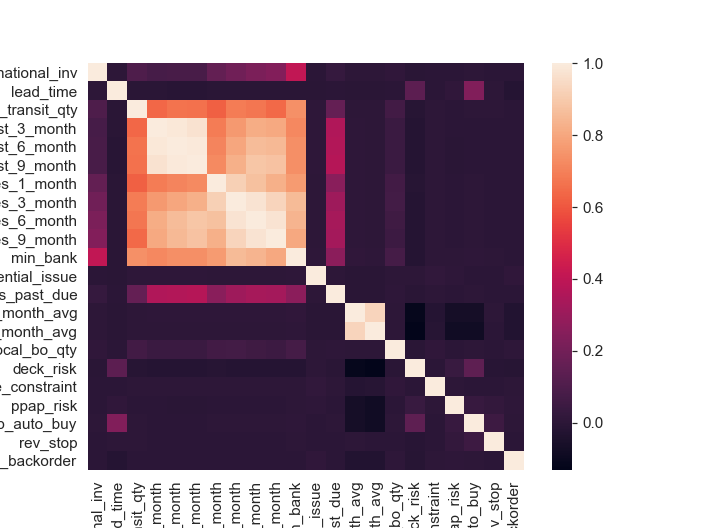

In [46]:
%matplotlib notebook
sns.heatmap(train_df.as_data_frame().corr())

In [47]:
h2o.init(nthreads=-1)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,14 mins 04 secs
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.3
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_Sumit_Keshav_yro6fx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.760 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [48]:
train_df['went_on_backorder'] = train_df['went_on_backorder'].asfactor()
test_df['went_on_backorder'] = test_df['went_on_backorder'].asfactor()

In [49]:
## Spliting Dataset where target is OOS as test and InStock as train

x_test_ac  = train_df[train_df['went_on_backorder'] == '1']
x_train_ac = train_df[train_df['went_on_backorder'] == '0']

In [50]:
print("test shape",x_test_ac.shape)
print("train shape",x_train_ac.shape)

test shape (13981, 22)
train shape (1915954, 22)


In [51]:
#Dropping SKU column
X= list(range(0,22))

In [52]:
### Auto Encoder Model
autoencoder_model = H2OAutoEncoderEstimator(activation="Tanh",
                                          hidden=[50,20,5,20,50],
                                          ignore_const_cols = False,
                                           stopping_metric='MSE', 
                                            stopping_tolerance=0.00001,
                                              epochs=200)
autoencoder_model.train(x =X, training_frame = x_train_ac)
print("MSE = ",autoencoder_model.mse(),"%")

deeplearning Model Build progress: |██████████████████████████████████████| 100%
MSE =  7.85475298713659e-05 %


#### Anomaly Detection (Whether SKU will be in stock or out of stock)

In [53]:
train_rec_error = autoencoder_model.anomaly(x_train_ac)
test_rec_error = autoencoder_model.anomaly(x_test_ac)

train_rec_error = train_rec_error.as_data_frame()
train_rec_error['id'] = train_rec_error.index.values + 1
train_rec_error['went_on_backorder']= 0



In [54]:
train_rec_error.head(10)

,Reconstruction.MSE,id,went_on_backorder
0,2.344952e-06,1,0
1,2.393055e-06,2,0
2,1.491752e-07,3,0
3,1.263149e-04,4,0
4,2.392021e-06,5,0
5,3.151479e-06,6,0
6,1.678010e-05,7,0
7,5.452695e-05,8,0
8,2.392099e-06,9,0
9,3.873586e-06,10,0


In [55]:
count_train_records = len(train_rec_error)
test_rec_error = test_rec_error.as_data_frame()
test_rec_error['id']=count_train_records+test_rec_error.index+1

test_rec_error['went_on_backorder']=1

rec_error = pd.concat([train_rec_error,test_rec_error],axis='index')

##### Visualizing Outliers

<IPython.core.display.Javascript object>


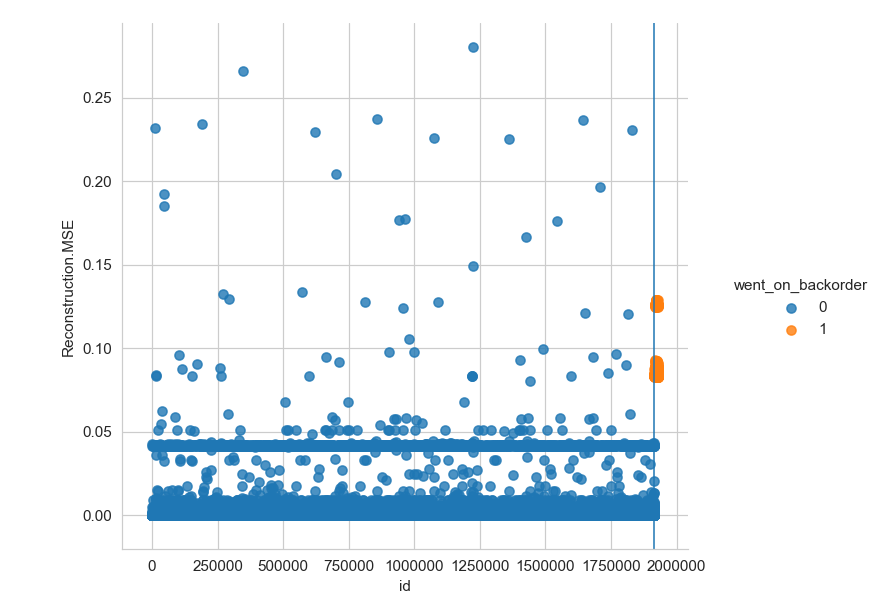

In [56]:
#Scatter Plot to see the outlier behaviour
%config InlineBackend.figure_format = 'retina'
#plt.figure(dpi=300,figsize=(15,40))
sns.lmplot(x='id',y='Reconstruction.MSE',data=rec_error,hue='went_on_backorder',fit_reg=False)
plt.axvline(x=count_train_records,linewidth=1)
plt.show()

<IPython.core.display.Javascript object>


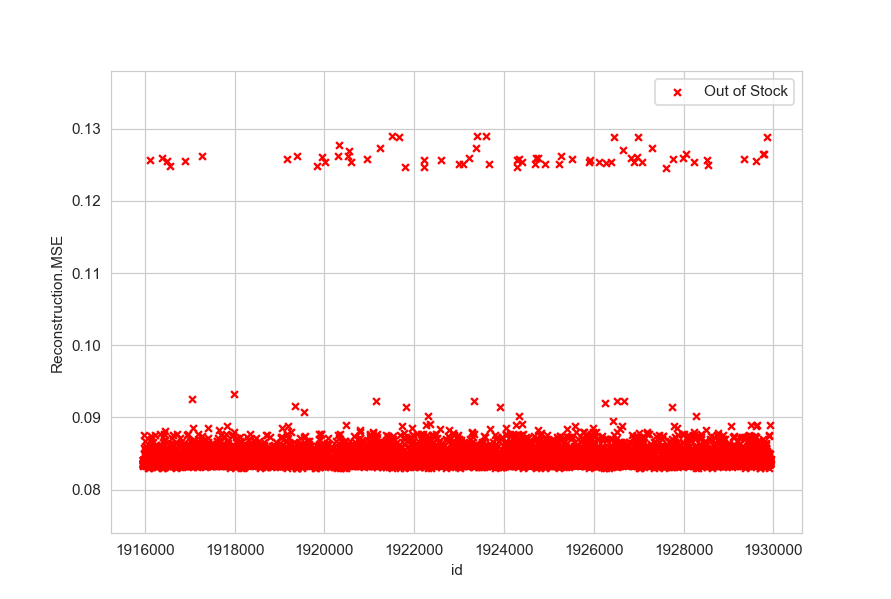

<IPython.core.display.Javascript object>


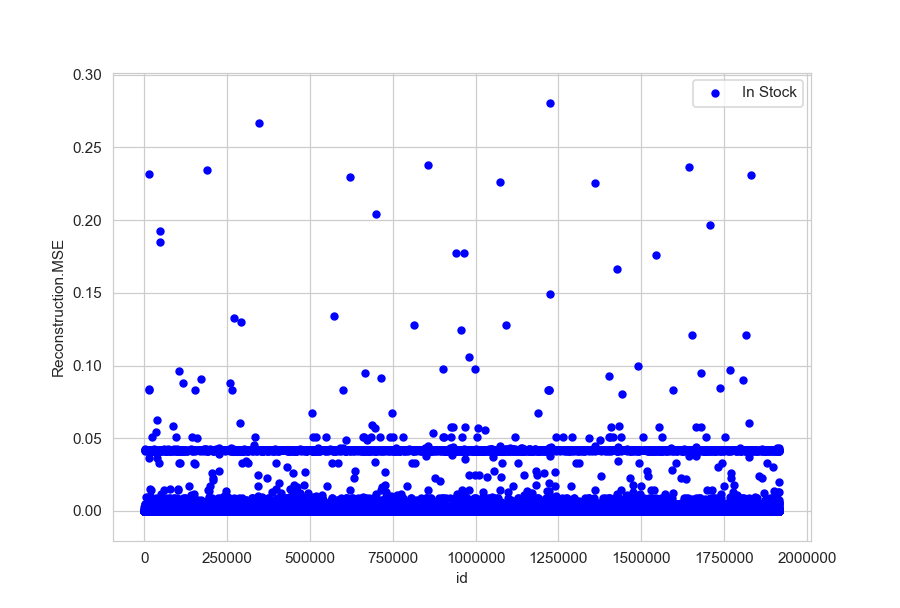

In [57]:
rec_error[rec_error['went_on_backorder'] == 1].plot(kind='scatter', x='id', y='Reconstruction.MSE',c='red',marker='x', label='Out of Stock')
rec_error[rec_error['went_on_backorder'] == 0].plot(kind='scatter', x='id', y='Reconstruction.MSE',c='blue',marker='o', label='In Stock')
plt.legend(loc='upper right')
plt.show()

 We identify these outliers and remove the corresponding IDs for further modeling. Choosing an upper limit for Reconstruction MSE from the scatterplot , i.e 0.15 

In [58]:
instock_ids = rec_error[rec_error.where(rec_error['Reconstruction.MSE']<0.15)['went_on_backorder']==0][['id']]

In [59]:
instock_ids.to_csv('inlier_ids.csv',index=None)

#### A small Anomaly detection model to run on the test set

In [60]:
rec_error_hf = autoencoder_model.anomaly(test_df)
rec_error_hf['actual'] = test_df['went_on_backorder']
rec_error_hf = rec_error_hf.as_data_frame()
rec_error_hf['id'] = rec_error_hf.index.values
rec_error_hf['predict'] = 0

#predict = [1 if e > threshold else 0 for e in rec_error_fh.reconstruction_error.values]

rec_error_hf['predict'][rec_error_hf['Reconstruction.MSE']  >0.079] = 1


df_confusion = pd.crosstab(rec_error_hf['actual'], rec_error_hf['predict'], rownames=['Actual'], colnames=['Predicted'], margins=True)
print(df_confusion)
print("---"*25)
print("\n % \n")
print(pd.crosstab(rec_error_hf['actual'], rec_error_hf['predict'], rownames=['True'], colnames=['Predicted']).apply(lambda r: 100.0 * r/r.sum()))

C:\Users\Sumit Keshav\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Predicted       0     1     All
Actual                         
0          479031    14  479045
1               0  5106    5106
All        479031  5120  484151
---------------------------------------------------------------------------

 % 

Predicted      0          1
True                       
0          100.0   0.273438
1            0.0  99.726562


<IPython.core.display.Javascript object>


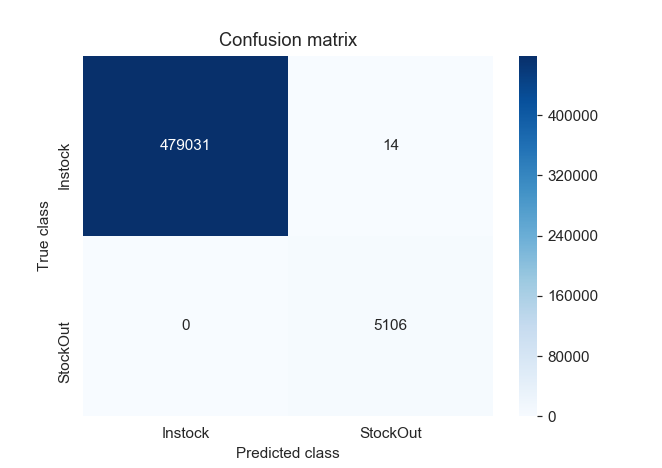

In [62]:
from sklearn.metrics import confusion_matrix

LABELS = LABELS = ['Instock', 'StockOut']
conf_matrix = confusion_matrix(rec_error_hf['actual'], rec_error_hf['predict'])
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",cmap=plt.cm.Blues);
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()


In [63]:
#Comments

In [64]:
test_df.as_data_frame()['went_on_backorder'].value_counts()

0    479045
1      5106
Name: went_on_backorder, dtype: int64